In [1]:
# Step 1: Upload the CSV file
from google.colab import files
uploaded = files.upload()


Saving customer_segmentation.csv to customer_segmentation.csv


In [2]:
# Step 2: Load and preview the dataset
import pandas as pd


df = pd.read_csv("customer_segmentation.csv", encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Step 3: Preprocessing
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
# Step 4: Feature Engineering (RFM Features)
from datetime import datetime


snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': ['sum', 'mean']
})


rfm.columns = ['Recency', 'Frequency', 'Monetary', 'AOV']
rfm = rfm.reset_index()
rfm.head()


,CustomerID,Recency,Frequency,Monetary,AOV
0,12346.0,326,1,77183.60,77183.600000
1,12347.0,2,7,4310.00,23.681319
2,12348.0,75,4,1797.24,57.975484
3,12349.0,19,1,1757.55,24.076027
4,12350.0,310,1,334.40,19.670588


In [5]:
# Step 5: Define Target Variable (LTV)

rfm['LTV'] = rfm['Monetary']


In [6]:
# Step 6: Train the Regression Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import numpy as np


X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['LTV']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = XGBRegressor()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


In [7]:
# Step 7: Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1351.14
RMSE: 8499.11


In [8]:
# Step 8: Predict LTV for all customers and segment them
rfm['Predicted_LTV'] = model.predict(X)

rfm['Segment'] = pd.qcut(rfm['Predicted_LTV'], 3, labels=['Low', 'Medium', 'High'])

rfm.head()


,CustomerID,Recency,Frequency,Monetary,AOV,LTV,Predicted_LTV,Segment
0,12346.0,326,1,77183.60,77183.600000,77183.60,76453.000000,High
1,12347.0,2,7,4310.00,23.681319,4310.00,3889.261963,High
2,12348.0,75,4,1797.24,57.975484,1797.24,1798.554810,High
3,12349.0,19,1,1757.55,24.076027,1757.55,357.891907,Low
4,12350.0,310,1,334.40,19.670588,334.40,296.488281,Low


In [9]:
# Step 9: Save Results
rfm.to_csv("final_ltv_predictions.csv", index=False)
print("Saved as final_ltv_predictions.csv")


Saved as final_ltv_predictions.csv


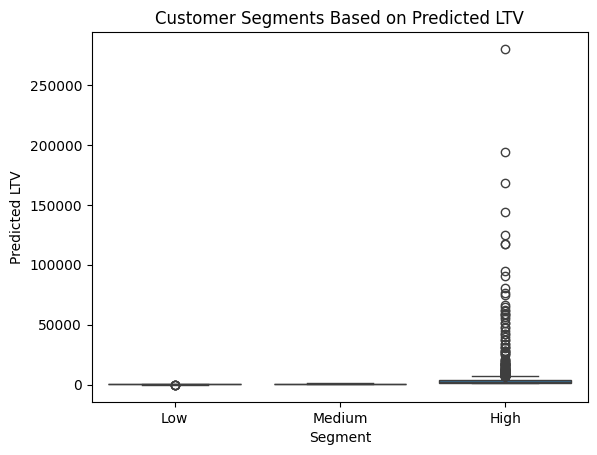

In [10]:
# Step 10: Visualize LTV Segments
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Segment', y='Predicted_LTV', data=rfm)
plt.title("Customer Segments Based on Predicted LTV")
plt.xlabel("Segment")
plt.ylabel("Predicted LTV")
plt.show()
